In [1]:
%matplotlib inline
from utils import read, createGraph, readGenders, functionals
import networkx as nx
from glob import iglob as glob
from os.path import exists, basename
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import numpy as np
import scipy as sp
import pickle
import warnings

plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
th = 2
data_dir = "./data/by_movie/*"
info_dir = "./data/speakersWithCharacterInfo/"
genre_file = "./data/genres.pickle"

## Read all scripts

In [3]:
genres = pickle.load(open(genre_file, 'rb'))

data = {}
for script in glob(data_dir):
    
    movie, char_list, adj = read(script, threshold = th)

    gender_file = info_dir + basename(script).replace(".", "_") + ".txt"
    if exists(gender_file):
        gens = readGenders(gender_file)
    else:
        gens = defaultdict(lambda: 'unknown')

    G = createGraph(char_list, adj, gens)


    key = basename(script)

    data[key] = {}
    data[key]['graph'] = G
    data[key]['chars'] = char_list
    data[key]['genres'] = genres.get(movie, [])

# Pre-check
In [GENDER BIAS WITHOUT BORDERS](http://seejane.org/wp-content/uploads/gender-bias-without-borders-executive-summary.pdf), there is a ratio of 2.25 men for every women on screen (women = $30.9$%). Lets check our numbers.

In [4]:
total, males, females = 0, 0, 0
for _, d in data.items():
    G = d['graph']
    
    for i in G.nodes():
        if G.node[i]['gender'] == 'male':
            males += 1
        elif G.node[i]['gender'] == 'female':
            females += 1
        
        total += 1
        
print("total: {}".format(total))
print("males: {:.2f}%".format(float(males) / total))
print("females: {:.2f}%".format(float(females) / total))


total: 14456
males: 0.37%
females: 0.16%


What if we drop unknown?... shouldn't matter right?

In [5]:
print("males: {:.2f}%".format(float(males) / (males + females)))
print("females: {:.2f}%".format(float(females) / (males + females)))

males: 0.70%
females: 0.30%


# Graph analysis

# Degree centrality

#### Average degree

In [6]:
warnings.simplefilter("ignore")
male_deg, female_deg = [], []
for script, d in data.items():
    G = d['graph']
    degrees = nx.degree(G)
    
    male_deg.append(np.mean([degrees[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
    female_deg.append(np.mean([degrees[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))

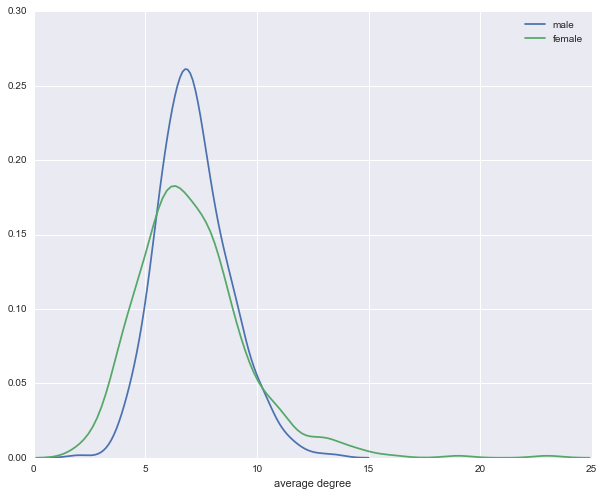

In [7]:
sns.distplot(male_deg, hist = False, label = "male");
sns.distplot(female_deg, hist = False, label = "female");
plt.legend();
plt.xlabel("average degree");

There is no real difference in the number of connections between men and women.

In [8]:
#Remove nans
male_deg, female_deg = np.array(male_deg), np.array(female_deg)
male_deg = male_deg[~np.isnan(male_deg)]
female_deg = female_deg[~np.isnan(female_deg)]


sp.stats.ttest_ind(male_deg, female_deg)

Ttest_indResult(statistic=0.66854780460708829, pvalue=0.50394934333620589)

### Based on Genre

In [37]:
res = []
types = [z for x in genres.values() for y in x for z in y]
for t in types:
    if type(t) == str:
        res.append(t)
    else:
        res.append([z for z in t][0])
types = sorted(list(set(filter(lambda x: len(x) > 2, map(lambda x: x.strip(), res)))))
types;

In [38]:
res = {}
for t in types:
    male_deg, female_deg = [], []
    for script, d in data.items():
        
        if t not in d['genres']:
            continue 
            
        G = d['graph']
        degrees = nx.degree(G)

        male_deg.append(np.mean([degrees[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
        female_deg.append(np.mean([degrees[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))
    
    res[t] = {}
    res[t]['male'] = male_deg
    res[t]['female'] = female_deg

In [39]:
# Pass into long format
tmp = []
for t, k in res.items():
    for g, v in k.items():
        for i in v:
            tmp.append((t, g, i))

tmp = pd.DataFrame(tmp, columns=["genre", "gender", "value"])

#Drop nan's
tmp = tmp[(tmp.genre!="Documentary")]
tmp = tmp[(tmp.genre!="Short")]
tmp = tmp[(tmp.genre!="Reality-TV")]

tmp.head()

,genre,gender,value
0,Western,female,4.000000
1,Western,female,6.000000
2,Western,female,5.375000
3,Western,female,12.500000
4,Western,female,7.142857


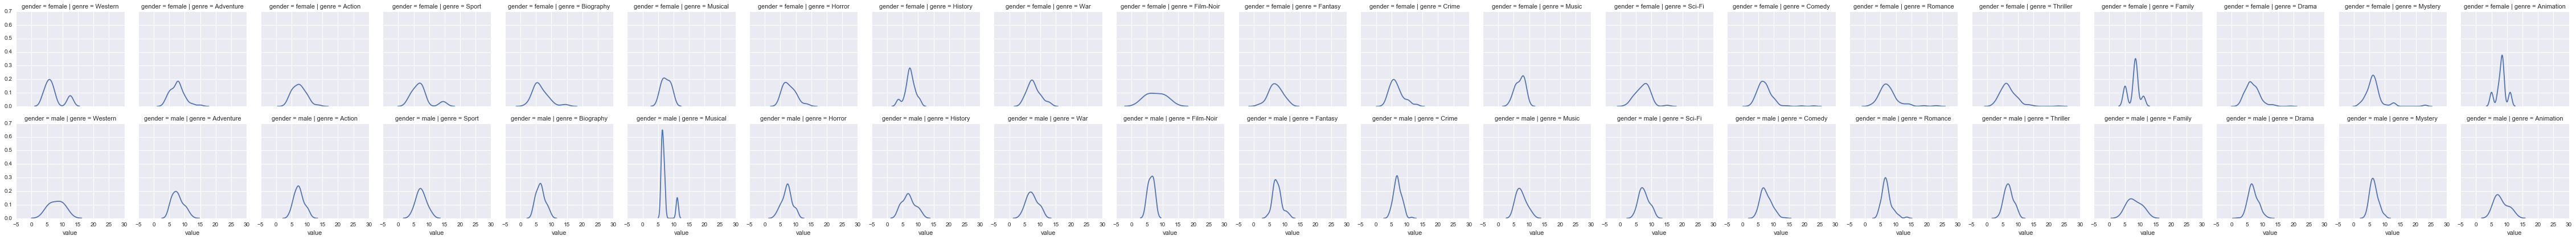

In [40]:
g = sns.FacetGrid(tmp, col = "genre", row = "gender")
g = g.map(sns.distplot, "value", hist=False)

In [ ]:
res = {}
for t in types:
    male_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "male"), "value"]
    female_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "female"), "value"]
    
    #Remove nans
    male_deg, female_deg = np.array(male_deg), np.array(female_deg)
    male_deg = male_deg[~np.isnan(male_deg)]
    female_deg = female_deg[~np.isnan(female_deg)]

    ttest = sp.stats.ttest_ind(male_deg, female_deg)

    if not np.isnan(ttest.pvalue):
        res[t] = ttest
    
res;

__There are no significant differences between the degrees based on gender.__

In [42]:
# Using Benjamin-Hochberg's method
res_2 = sorted(res.items(), key = lambda x: x[1].pvalue)
m = len(res_2)

i = 1
while i < len(res_2) + 1:
    if res_2[i - 1][1].pvalue > i / m * 0.05:
        break
    i = i + 1
        
res_2[:(i - 1)]

[]


# Betweeness Centrality

#### Average centrality

In [43]:
male_cent, female_cent = [], []
for script, d in data.items():
    G = d['graph']
    cents = nx.betweenness_centrality(G)
    
    male_cent.append(np.mean([cents[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
    female_cent.append(np.mean([cents[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))

Just a quick note, this is a _density_, not a probability. The AUC adds up to 1. 

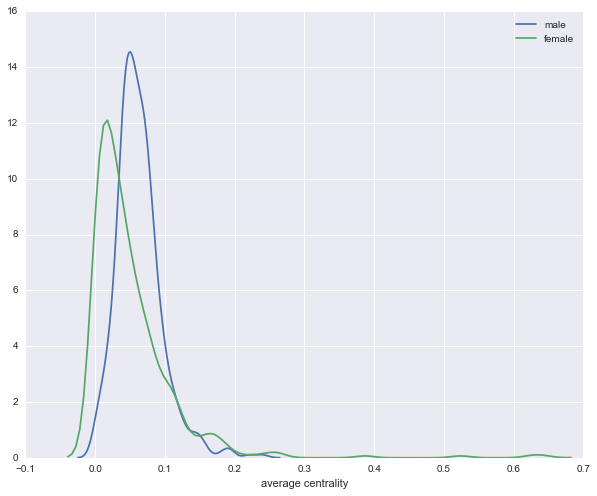

In [16]:
sns.distplot(male_cent, hist = False, label = "male");
sns.distplot(female_cent, hist = False, label = "female");
plt.legend();
plt.xlabel("average centrality");

In this case, there is a significant difference in the average centrality of male characters and female characters ($t(?) = 2.7951,\, p < 0.01$). In most of the scripts, males occupy a more central role than females.

In [44]:
#Remove nans
male_cent, female_cent = np.array(male_cent), np.array(female_cent)
male_cent = male_cent[~np.isnan(male_cent)]
female_cent = female_cent[~np.isnan(female_cent)]


sp.stats.ttest_ind(male_cent, female_cent)

Ttest_indResult(statistic=3.2939679380840032, pvalue=0.0010250046869674501)

### Condition on Genre

In [45]:
res = {}
for t in types:
    male_centr, female_centr = [], []
    for script, d in data.items():
        
        if t not in d['genres']:
            continue 
            
        G = d['graph']
        centralities = nx.betweenness_centrality(G)

        male_centr.append(np.mean([centralities[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
        female_centr.append(np.mean([centralities[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))
    
    res[t] = {}
    res[t]['male'] = male_centr
    res[t]['female'] = female_centr

In [46]:
# Pass into long format
tmp = []
for t, k in res.items():
    for g, v in k.items():
        for i in v:
            tmp.append((t, g, i))

tmp = pd.DataFrame(tmp, columns=["genre", "gender", "value"])

#Drop nan's
tmp = tmp[(tmp.genre!="Documentary")]
tmp = tmp[(tmp.genre!="Short")]
tmp = tmp[(tmp.genre!="Reality-TV")]

tmp.head()

,genre,gender,value
0,Western,female,0.015115
1,Western,female,0.002525
2,Western,female,0.050165
3,Western,female,0.055344
4,Western,female,0.004726


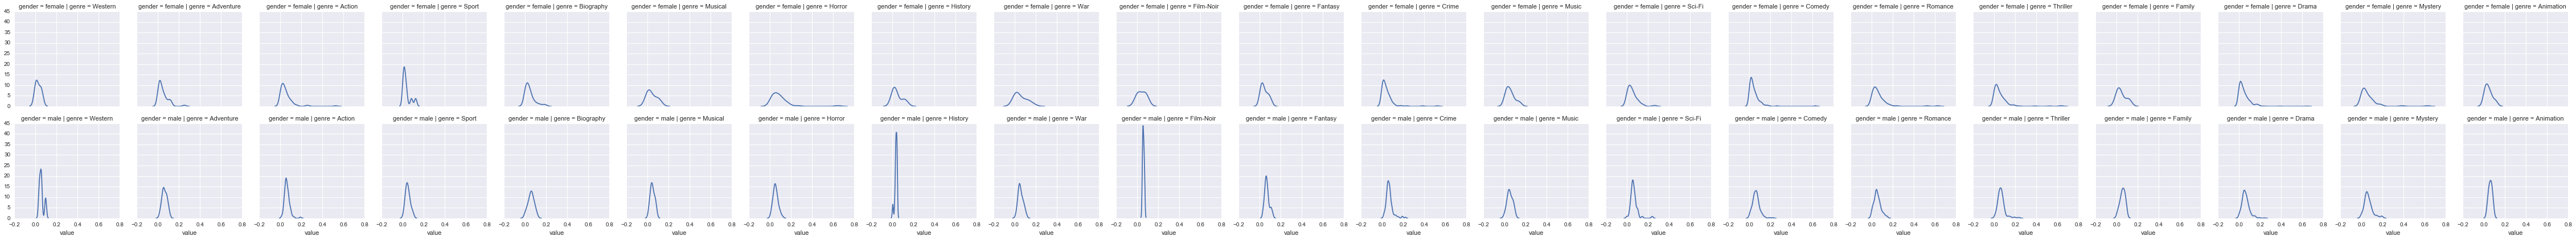

In [20]:
g = sns.FacetGrid(tmp, col = "genre", row = "gender")
g = g.map(sns.distplot, "value", hist=False)

In [47]:
res = {}
for t in types:
    male_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "male"), "value"]
    female_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "female"), "value"]
    
    #Remove nans
    male_deg, female_deg = np.array(male_deg), np.array(female_deg)
    male_deg = male_deg[~np.isnan(male_deg)]
    female_deg = female_deg[~np.isnan(female_deg)]

    ttest = sp.stats.ttest_ind(male_deg, female_deg)

    if not np.isnan(ttest.pvalue):
        res[t] = ttest
    
res;

__ There is a real difference in the centrality of characters in Crime movies __

In [48]:
# Using Benjamin-Hochberg's method
res_2 = sorted(res.items(), key = lambda x: x[1].pvalue)
m = len(res_2)

i = 1
while i < len(res_2) + 1:
    if res_2[i - 1][1].pvalue > i / m * 0.05:
        break
    i = i + 1
        
res_2[:(i - 1)]

[('Crime',
  Ttest_indResult(statistic=3.1232004923580439, pvalue=0.0020364057864579363))]

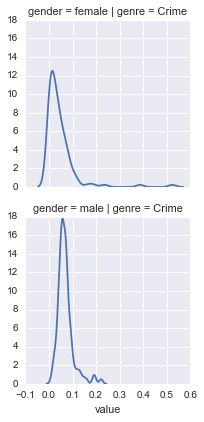

In [49]:
g = sns.FacetGrid(tmp[tmp.genre == "Crime"], col = "genre", row = "gender")
g = g.map(sns.distplot, "value", hist=False)

# Triads and love triangles
Can we say that love triangles are really that common?

In [23]:
def countTrianglesByGender(G):
    triangles = []

    for i in G.nodes():
        for j in G.neighbors(i):
            if j == i:
                continue 

            for k in G.neighbors(j):
                if k == j or k == i:
                    continue

                if i in G.neighbors(k):
                    triangles.append(tuple(sorted([i, j, k])))

    triangles = set(triangles)
    triangles_genders = map(lambda x: map(lambda _: G.node[_]['gender'], x), triangles)
    
    return Counter(list(map(lambda x: tuple(sorted(list(x))), triangles_genders)))

__Same gender triangles are the least common!!__

In [24]:
genderTriangs = sum(map(countTrianglesByGender, [d['graph'] for d in data.values()]), Counter())
genderTriangs

Counter({('female', 'female', 'female'): 585,
         ('female', 'female', 'male'): 3096,
         ('female', 'female', 'unknown'): 640,
         ('female', 'male', 'male'): 7587,
         ('female', 'male', 'unknown'): 3438,
         ('female', 'unknown', 'unknown'): 583,
         ('male', 'male', 'male'): 6288,
         ('male', 'male', 'unknown'): 4720,
         ('male', 'unknown', 'unknown'): 1744,
         ('unknown', 'unknown', 'unknown'): 9381})

### Based on genre

In [25]:
typeTriangs = {}
for t in types:
    typeTriangs[t] = sum(map(countTrianglesByGender, [d['graph'] for d in data.values() if t in d['genres']]), Counter())
    
typeTriangs;

In [26]:
typeTriangs_df = []
for t in types:
    for k in typeTriangs[t]:
        typeTriangs_df.append((t, k, typeTriangs[t][k]))
typeTriangs_df = pd.DataFrame(typeTriangs_df, columns = ["genre", "type", "value"])
typeTriangs_df.head()

,genre,type,value
0,Action,"(male, unknown, unknown)",363
1,Action,"(female, female, unknown)",65
2,Action,"(female, male, male)",1565
3,Action,"(female, female, male)",474
4,Action,"(female, male, unknown)",640


In [27]:
#Drop unknown
typeTriangs_df = typeTriangs_df[~np.array(['unknown' in t for t in typeTriangs_df.type])]
typeTriangs_df.head()

#Normalize
totals = typeTriangs_df.groupby("genre").agg({'value':'sum'})
df = pd.Series(index = typeTriangs_df.index)
for idx, row in typeTriangs_df.iterrows():
    df[idx] = (typeTriangs_df.ix[idx, 'value'] / totals.ix[typeTriangs_df.ix[idx, 'genre']])

typeTriangs_df['value'] = df    
    
typeTriangs_df.head()

,genre,type,value
2,Action,"(female, male, male)",0.454150
3,Action,"(female, female, male)",0.137551
8,Action,"(male, male, male)",0.397272
9,Action,"(female, female, female)",0.011027
12,Adventure,"(female, female, male)",0.108604


* __ ('male', 'male', 'male') is the most popular in western and sports movies __
* __ ('female', 'female', 'female') do not appear that much. Mostly on Comedy and Romance __

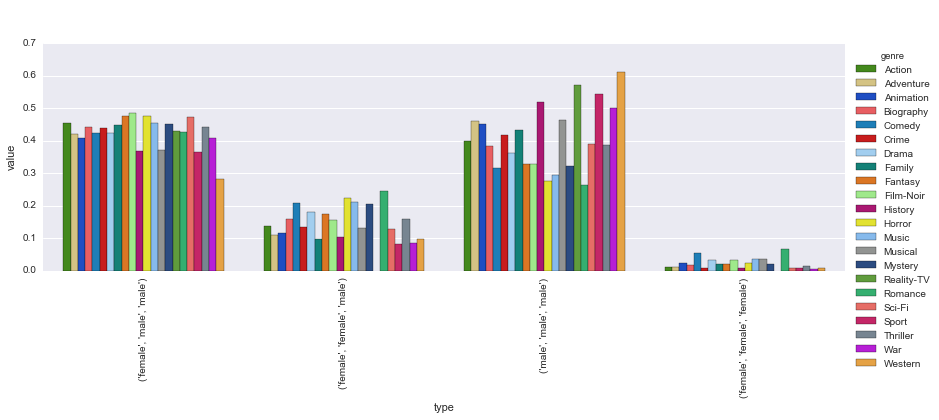

In [28]:
xkcd_colors = sns.xkcd_palette(["grass green", "sand", "blue", "light red", "cerulean",
                                "red", "light blue", "teal", "orange", "light green",
                                "magenta", "yellow", "sky blue", "grey", "cobalt",
                                "grass", "algae green", "coral", "cerise", "steel",
                                "hot purple", "mango", "pale lime", "rouge"])

g = sns.factorplot("type", "value", hue="genre", data = typeTriangs_df, kind = "bar", aspect = 3, palette=xkcd_colors);
g.set_xticklabels(rotation=90);